In [1]:
import sys
import os
import subprocess
import tarfile
import shutil
from functools import partial
from tqdm import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (random_split, DataLoader, TensorDataset, ConcatDataset)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from Bio import motifs

import boda
from boda.generator.parameters import StraightThroughParameters
from boda.generator import FastSeqProp
from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm
from boda.model.mpra_basset import MPRA_Basset
from boda.common import constants, utils

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn
from pymeme import streme, parse_streme_output

In [22]:
#----------------------- ReLU6 model -----------------------
if os.path.isdir('./artifacts'):
    shutil.rmtree('./artifacts')
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211110_194934__672830.tar.gz'
unpack_artifact(hpo_rec)

model_dir = './artifacts'
relu6_model = model_fn(model_dir)
relu6_model.eval()

Loaded model from 20211110_194934 in eval mode


BassetBranched(
  (pad1): ConstantPad1d(padding=(9, 9), value=0.0)
  (conv1): Conv1dNorm(
    (conv): Conv1d(4, 300, kernel_size=(19,), stride=(1,))
    (bn_layer): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad2): ConstantPad1d(padding=(5, 5), value=0.0)
  (conv2): Conv1dNorm(
    (conv): Conv1d(300, 200, kernel_size=(11,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad3): ConstantPad1d(padding=(3, 3), value=0.0)
  (conv3): Conv1dNorm(
    (conv): Conv1d(200, 200, kernel_size=(7,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad4): ConstantPad1d(padding=(1, 1), value=0.0)
  (maxpool_3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (maxpool_4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (linear1): LinearNorm(
    (linear): Linear(in

In [2]:
#----------------------- Non-HD model -----------------------
if os.path.isdir('./artifacts'):
    shutil.rmtree('./artifacts')
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211113_021200__287348.tar.gz'
unpack_artifact(hpo_rec)

model_dir = './artifacts'
usual_model = model_fn(model_dir)
usual_model.eval()

Loaded model from 20211113_021200 in eval mode


BassetBranched(
  (pad1): ConstantPad1d(padding=(9, 9), value=0.0)
  (conv1): Conv1dNorm(
    (conv): Conv1d(4, 300, kernel_size=(19,), stride=(1,))
    (bn_layer): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad2): ConstantPad1d(padding=(5, 5), value=0.0)
  (conv2): Conv1dNorm(
    (conv): Conv1d(300, 200, kernel_size=(11,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad3): ConstantPad1d(padding=(3, 3), value=0.0)
  (conv3): Conv1dNorm(
    (conv): Conv1d(200, 200, kernel_size=(7,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad4): ConstantPad1d(padding=(1, 1), value=0.0)
  (maxpool_3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (maxpool_4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (linear1): LinearNorm(
    (linear): Linear(in

In [3]:
#----------------------- HD model -----------------------
if os.path.isdir('./artifacts'):
    shutil.rmtree('./artifacts')
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211119_011437__338420.tar.gz'
unpack_artifact(hpo_rec)

model_dir = './artifacts'
HD_model = model_fn(model_dir)
HD_model.eval()

Loaded model from 20211119_011437 in eval mode


BassetBranched(
  (pad1): ConstantPad1d(padding=(9, 9), value=0.0)
  (conv1): Conv1dNorm(
    (conv): Conv1d(4, 300, kernel_size=(19,), stride=(1,))
    (bn_layer): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad2): ConstantPad1d(padding=(5, 5), value=0.0)
  (conv2): Conv1dNorm(
    (conv): Conv1d(300, 200, kernel_size=(11,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad3): ConstantPad1d(padding=(3, 3), value=0.0)
  (conv3): Conv1dNorm(
    (conv): Conv1d(200, 200, kernel_size=(7,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad4): ConstantPad1d(padding=(1, 1), value=0.0)
  (maxpool_3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (maxpool_4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (linear1): LinearNorm(
    (linear): Linear(in

In [4]:
df = pd.read_csv('gs://syrgoth/data/MPRA_ALL_no_cutoffs.txt', sep=" ", low_memory=False)

In [5]:
test_df = df[(df['chr'] == '7') | (df['chr'] == '13')].reset_index(drop=True)

In [6]:
test_df

HepG2_mean  HepG2_std  ID_count                    IDs  K562_mean  \
0        0.233601        NaN         1    7:70038969:G:T:A:wC   0.060779   
1        0.154811   0.078127         1  7:4682252:T:TTTG:A:wC   0.251481   
2        0.264553   0.184777         1  7:4682252:T:TTTG:R:wC   0.207406   
3       -0.159498        NaN         1    7:26792481:T:G:A:wC   0.569506   
4       -0.382856        NaN         1    7:26792481:T:G:R:wC  -0.125233   
...           ...        ...       ...                    ...        ...   
66707    0.262422        NaN         1       7:91906182:NA:NA  -0.331317   
66708    0.677389        NaN         1      7:128762416:NA:NA   0.877790   
66709   -0.180785        NaN         1       7:91906782:NA:NA  -0.248728   
66710   -0.743857        NaN         1      13:98991732:NA:NA  -0.502905   
66711   -0.309216        NaN         1       7:70186653:NA:NA  -0.467697   

       K562_std     OL  OL_count  SKNSH_mean  SKNSH_std  ... ctrl_mean_k562  \
0           NaN     29       1.0    0.047194        NaN  ...    1108.444552   
1       0.10549  27,32       2.0    0.198428   0.049655  ...     952.112631   
2       0.12414  27,32       2.0    0.194314   0.158508  ...     865.613336   
3           NaN     32       1.0    0.244310        NaN  ...     116.692922   
4           NaN     32       1.0   -0.415536        NaN  ...     127.489585   
...         ...    ...       ...         ...        ...  ...            ...   
66707       NaN    NaN       NaN   -0.074696        NaN  ...     163.125827   
66708       NaN    NaN       NaN    0.870688        NaN  ...     320.079226   
66709       NaN    NaN       NaN    0.293823        NaN  ...     288.236589   
66710       NaN    NaN       NaN   -0.773449        NaN  ...     169.466357   
66711       NaN    NaN       NaN   -0.746165        NaN  ...     264.685880   

      ctrl_mean_sknsh  data_project  exp_mean_hepg2  exp_mean_k562  \
0         1108.444552          UKBB     1301.918204    1155.970884   
1          952.112631          UKBB     1092.894239    1076.005372   
2          865.613336          UKBB      951.148078     940.362313   
3          116.692922          UKBB      104.407160     173.137321   
4          127.489585          UKBB       97.813590     116.879297   
...               ...           ...             ...            ...   
66707      163.125827          BODA      195.692813     129.495523   
66708      320.079226          BODA      511.829834     588.561948   
66709      288.236589          BODA      254.395904     242.835950   
66710      169.466357          BODA      101.216169     119.203435   
66711      264.685880          BODA      213.622243     191.571677   

      exp_mean_sknsh  lfcSE_hepg2  lfcSE_k562  lfcSE_sknsh  \
0        1144.967937     0.118254    0.098795     0.130671   
1        1066.518196     0.165529    0.160158     0.136867   
2         916.484837     0.140279    0.142918     0.141129   
3         138.228808     0.466496    0.375587     0.377180   
4          95.345017     0.533079    0.539165     0.839409   
...              ...          ...         ...          ...   
66707     154.915221     0.202467    0.193262     0.231167   
66708     585.211956     0.127092    0.112266     0.157581   
66709     353.314461     0.181582    0.151427     0.177588   
66710      99.196382     0.278566    0.204515     0.275525   
66711     157.898556     0.192305    0.159937     0.231315   

                                             nt_sequence  
0      CCTGGTCTTTCTTGCTAAATAAACATATCGTGCATCATCCAGATCT...  
1      CATAAATAAATAAACGAATGGGGAGGAAATTGATAAAATATTAAAA...  
2      CATAAATAAATAAACGAATGGGGAGGAAATTGATAAAATATTAAAA...  
3      CATAAACCTGGATGAAGATCATCTTAACACAAAAACAAATCAGCAA...  
4      CATAAACCTGGATGAAGATCATCTTAACACAAAAACAAATCAGCAA...  
...                                                  ...  
66707  CAGGCTTTTCAGAAGTGTCCTGATAATCAGGGTACACATGAAAGGA...  
66708  CAGGGTTCCCAGGAAGCCTCAATGCTGCCATTTTACAAAGGAAGAA...  
66709  CAGGGGTATTAAATGCATTTT

In [7]:
test_df[test_df['K562_mean'].notnull() & test_df['HepG2_mean'].notnull() & test_df['SKNSH_mean'].notnull()]

HepG2_mean  HepG2_std  ID_count                    IDs  K562_mean  \
0        0.233601        NaN         1    7:70038969:G:T:A:wC   0.060779   
1        0.154811   0.078127         1  7:4682252:T:TTTG:A:wC   0.251481   
2        0.264553   0.184777         1  7:4682252:T:TTTG:R:wC   0.207406   
3       -0.159498        NaN         1    7:26792481:T:G:A:wC   0.569506   
4       -0.382856        NaN         1    7:26792481:T:G:R:wC  -0.125233   
...           ...        ...       ...                    ...        ...   
66707    0.262422        NaN         1       7:91906182:NA:NA  -0.331317   
66708    0.677389        NaN         1      7:128762416:NA:NA   0.877790   
66709   -0.180785        NaN         1       7:91906782:NA:NA  -0.248728   
66710   -0.743857        NaN         1      13:98991732:NA:NA  -0.502905   
66711   -0.309216        NaN         1       7:70186653:NA:NA  -0.467697   

       K562_std     OL  OL_count  SKNSH_mean  SKNSH_std  ... ctrl_mean_k562  \
0           NaN     29       1.0    0.047194        NaN  ...    1108.444552   
1       0.10549  27,32       2.0    0.198428   0.049655  ...     952.112631   
2       0.12414  27,32       2.0    0.194314   0.158508  ...     865.613336   
3           NaN     32       1.0    0.244310        NaN  ...     116.692922   
4           NaN     32       1.0   -0.415536        NaN  ...     127.489585   
...         ...    ...       ...         ...        ...  ...            ...   
66707       NaN    NaN       NaN   -0.074696        NaN  ...     163.125827   
66708       NaN    NaN       NaN    0.870688        NaN  ...     320.079226   
66709       NaN    NaN       NaN    0.293823        NaN  ...     288.236589   
66710       NaN    NaN       NaN   -0.773449        NaN  ...     169.466357   
66711       NaN    NaN       NaN   -0.746165        NaN  ...     264.685880   

      ctrl_mean_sknsh  data_project  exp_mean_hepg2  exp_mean_k562  \
0         1108.444552          UKBB     1301.918204    1155.970884   
1          952.112631          UKBB     1092.894239    1076.005372   
2          865.613336          UKBB      951.148078     940.362313   
3          116.692922          UKBB      104.407160     173.137321   
4          127.489585          UKBB       97.813590     116.879297   
...               ...           ...             ...            ...   
66707      163.125827          BODA      195.692813     129.495523   
66708      320.079226          BODA      511.829834     588.561948   
66709      288.236589          BODA      254.395904     242.835950   
66710      169.466357          BODA      101.216169     119.203435   
66711      264.685880          BODA      213.622243     191.571677   

      exp_mean_sknsh  lfcSE_hepg2  lfcSE_k562  lfcSE_sknsh  \
0        1144.967937     0.118254    0.098795     0.130671   
1        1066.518196     0.165529    0.160158     0.136867   
2         916.484837     0.140279    0.142918     0.141129   
3         138.228808     0.466496    0.375587     0.377180   
4          95.345017     0.533079    0.539165     0.839409   
...              ...          ...         ...          ...   
66707     154.915221     0.202467    0.193262     0.231167   
66708     585.211956     0.127092    0.112266     0.157581   
66709     353.314461     0.181582    0.151427     0.177588   
66710      99.196382     0.278566    0.204515     0.275525   
66711     157.898556     0.192305    0.159937     0.231315   

                                             nt_sequence  
0      CCTGGTCTTTCTTGCTAAATAAACATATCGTGCATCATCCAGATCT...  
1      CATAAATAAATAAACGAATGGGGAGGAAATTGATAAAATATTAAAA...  
2      CATAAATAAATAAACGAATGGGGAGGAAATTGATAAAATATTAAAA...  
3      CATAAACCTGGATGAAGATCATCTTAACACAAAAACAAATCAGCAA...  
4      CATAAACCTGGATGAAGATCATCTTAACACAAAAACAAATCAGCAA...  
...                                                  ...  
66707  CAGGCTTTTCAGAAGTGTCCTGATAATCAGGGTACACATGAAAGGA...  
66708  CAGGGTTCCCAGGAAGCCTCAATGCTGCCATTTTACAAAGGAAGAA...  
66709  CAGGGGTATTAAATGCATTTT

In [8]:
test_df[test_df['K562_mean'].isna() | test_df['HepG2_mean'].isna() | test_df['SKNSH_mean'].isna()]

Empty DataFrame
Columns: [HepG2_mean, HepG2_std, ID_count, IDs, K562_mean, K562_std, OL, OL_count, SKNSH_mean, SKNSH_std, chr, class, ctrl_mean_hepg2, ctrl_mean_k562, ctrl_mean_sknsh, data_project, exp_mean_hepg2, exp_mean_k562, exp_mean_sknsh, lfcSE_hepg2, lfcSE_k562, lfcSE_sknsh, nt_sequence]
Index: []

[0 rows x 23 columns]

In [9]:
count = 0
for seq in list(test_df['nt_sequence']):
    if len(seq) != 200:
        count += 1
print(count)

2754


In [10]:
#for variable-length sequences
def get_predictions(in_df, model, eval_batch_size = 128, seq_column='nt_sequence'):
    temp_col_name = 'padded_seq'
    padding_fn = partial(utils.row_pad_sequence,
                            in_column_name=seq_column,
                            padded_seq_len=600)
    
    print('Padding sequences')
    in_df[temp_col_name] = in_df.progress_apply(padding_fn, axis=1) 
    sequence_list = list(in_df[temp_col_name]) 
    
    print('Tokenizing sequences')
    onehot_sequences = torch.stack([utils.dna2tensor(subsequence) for subsequence in tqdm(sequence_list)])

    temp_dataset = TensorDataset(onehot_sequences)
    temp_dataloader = DataLoader(temp_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=2)

    print('Getting predictions')  
    preds = []
    for local_batch in tqdm(temp_dataloader):
        preds.append(model(local_batch[0].cuda()).cpu().detach().numpy())
        
    preds_array = np.concatenate(preds, axis=0)
    return preds_array

In [11]:
usual_model.cuda()
preds_array_noHD = get_predictions(test_df, usual_model)

preds_df_noHD = pd.DataFrame(preds_array_noHD, columns=['K562_pred', 'HepG2_pred', 'SKNSH_pred'])
test_df = pd.concat([test_df, preds_df_noHD], axis=1)

Padding sequences


  0%|          | 0/66712 [00:00<?, ?it/s]

Tokenizing sequences


  0%|          | 0/66712 [00:00<?, ?it/s]

Getting predictions


  0%|          | 0/522 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [23]:
relu6_model.cuda()
preds_array_noHD = get_predictions(test_df, relu6_model)

preds_df_noHD = pd.DataFrame(preds_array_noHD, columns=['K562_pred6', 'HepG2_pred6', 'SKNSH_pred6'])
test_df = pd.concat([test_df, preds_df_noHD], axis=1)

Padding sequences


  0%|          | 0/66712 [00:00<?, ?it/s]

Tokenizing sequences


  0%|          | 0/66712 [00:00<?, ?it/s]

Getting predictions


  0%|          | 0/522 [00:00<?, ?it/s]

In [12]:
HD_model.cuda()
preds_array_HD = get_predictions(test_df, HD_model)

preds_df_HD = pd.DataFrame(preds_array_HD, columns=['K562_pred_HD', 'HepG2_pred_HD', 'SKNSH_pred_HD'])
test_df = pd.concat([test_df, preds_df_HD], axis=1)

Padding sequences


  0%|          | 0/66712 [00:00<?, ?it/s]

Tokenizing sequences


  0%|          | 0/66712 [00:00<?, ?it/s]

Getting predictions


  0%|          | 0/522 [00:00<?, ?it/s]

In [13]:
test_df

HepG2_mean  HepG2_std  ID_count                    IDs  K562_mean  \
0        0.233601        NaN         1    7:70038969:G:T:A:wC   0.060779   
1        0.154811   0.078127         1  7:4682252:T:TTTG:A:wC   0.251481   
2        0.264553   0.184777         1  7:4682252:T:TTTG:R:wC   0.207406   
3       -0.159498        NaN         1    7:26792481:T:G:A:wC   0.569506   
4       -0.382856        NaN         1    7:26792481:T:G:R:wC  -0.125233   
...           ...        ...       ...                    ...        ...   
66707    0.262422        NaN         1       7:91906182:NA:NA  -0.331317   
66708    0.677389        NaN         1      7:128762416:NA:NA   0.877790   
66709   -0.180785        NaN         1       7:91906782:NA:NA  -0.248728   
66710   -0.743857        NaN         1      13:98991732:NA:NA  -0.502905   
66711   -0.309216        NaN         1       7:70186653:NA:NA  -0.467697   

       K562_std     OL  OL_count  SKNSH_mean  SKNSH_std  ... lfcSE_k562  \
0           NaN     29       1.0    0.047194        NaN  ...   0.098795   
1       0.10549  27,32       2.0    0.198428   0.049655  ...   0.160158   
2       0.12414  27,32       2.0    0.194314   0.158508  ...   0.142918   
3           NaN     32       1.0    0.244310        NaN  ...   0.375587   
4           NaN     32       1.0   -0.415536        NaN  ...   0.539165   
...         ...    ...       ...         ...        ...  ...        ...   
66707       NaN    NaN       NaN   -0.074696        NaN  ...   0.193262   
66708       NaN    NaN       NaN    0.870688        NaN  ...   0.112266   
66709       NaN    NaN       NaN    0.293823        NaN  ...   0.151427   
66710       NaN    NaN       NaN   -0.773449        NaN  ...   0.204515   
66711       NaN    NaN       NaN   -0.746165        NaN  ...   0.159937   

      lfcSE_sknsh                                        nt_sequence  \
0        0.130671  CCTGGTCTTTCTTGCTAAATAAACATATCGTGCATCATCCAGATCT...   
1        0.136867  CATAAATAAATAAACGAATGGGGAGGAAATTGATAAAATATTAAAA...   
2        0.141129  CATAAATAAATAAACGAATGGGGAGGAAATTGATAAAATATTAAAA...   
3        0.377180  CATAAACCTGGATGAAGATCATCTTAACACAAAAACAAATCAGCAA...   
4        0.839409  CATAAACCTGGATGAAGATCATCTTAACACAAAAACAAATCAGCAA...   
...           ...                                                ...   
66707    0.231167  CAGGCTTTTCAGAAGTGTCCTGATAATCAGGGTACACATGAAAGGA...   
66708    0.157581  CAGGGTTCCCAGGAAGCCTCAATGCTGCCATTTTACAAAGGAAGAA...   
66709    0.177588  CAGGGGTATTAAATGCATTTTTGACTTGTGGTTTTGATTTACAGTG...   
66710    0.275525  CAGGAGAACAGCAAGGGGGAAATCTGCCCCCATGATCCAGCTACCT...   
66711    0.231315  CAGTGATCAGGTATTTGAGTGCCTACCTGACATTGTCTGAGAGACA...   

                                              padded_seq  K562_pred  \
0      GTACGGGAGGTATTGGACAGGCCGCAATAAAATATCTTTATTTTCA...   0.003263   
1      GTACGGGAGGTATTGGACAGGCCGCAATAAAATATCTTTATTTTCA...   0.368860   
2      GGTACGGGAGGTATTGGACAGGCCGCAATAAAATATCTTTATTTTC...   0.421951   
3      GTACGGGAGGTATTGGACAGGCCGCAATAAAATATCTTTATTTTCA...  -0.129422   
4      GTACGGGAGGTATTGGACAGGCCGCAATAAAATATCTTTATTTTCA...  -0.135592   
...                                                  ...        ...   
66707  GTACGGGAGGTATTGGACAGGCCGCAATAAAATATCTTTATTTTCA...  -0.174855   
66708  GTACGGGAGGTATTGGACAGGCCGCAATAAAATATCTTTATTTTCA...   1.032784   
66709  GTACGGGAGGTATTGGACAGGCCGCAATAAAATATCTTTATTTTCA...  -0.215499   
66710  GTACGGGAGGTATTGGACAGGCCGCAATAAAATATCTTTATTTTCA...  -0.189395   
66711  GTACGGGAGGTATTGGACAGGCCGCAATAAAATATCTTTATTTTCA...  -0.214195   

      HepG2_pred  SKNSH_pred  K562_pred_HD  HepG2_pred_HD  SKNSH_pred_HD  
0       0.443712    0.456891      0.002723       0.393186       0.382491  
1       0.322296    0.280158      0.400889       0.463009       0.397065  
2       0.414575    0.263614      0.322852       0.398447       0.355247  
3      -0.174615   -0.020271     -0.181847      -0.162712      -0.074971  
4      -0.171854   -0.084877     -0.182264      -0.156215      -0.091018  
...          ...         

In [14]:
def single_scatterplot(data_df, x_axis, y_axis, color_axis, fig_size=(15,8), dot_size=0.5, title='',
                       dot_alpha=0.5, style='seaborn-whitegrid', colormap='winter',
                       x_label='True', y_label='Predicted', color_label='l2fc SE', title_font_size=18,
                       title_font_weight='medium', axis_font_size=16):
    with plt.style.context(style):
        fig, ax = plt.subplots()    
        data_df.plot(kind='scatter', x=x_axis, y=y_axis, figsize=fig_size, c=color_axis, ax=ax,
                        alpha=dot_alpha, s=dot_size, colormap=colormap)
        plt.xlabel(x_label, fontsize=axis_font_size)
        plt.ylabel(y_label, fontsize=axis_font_size)

        f = plt.gcf()
        cax = f.get_axes()[1]
        cax.set_ylabel(color_label, fontsize=axis_font_size)

        x_min, y_min = data_df[[x_axis, y_axis]].min().to_numpy() 
        x_max, y_max = data_df[[x_axis, y_axis]].max().to_numpy()
        min_point, max_point = max(x_min, y_min), min(x_max, y_max)
        plt.plot((min_point,max_point), (min_point,max_point), color='black', linestyle='--', alpha=0.5)

        Pearson = round(data_df[[x_axis, y_axis]].corr(method='pearson')[x_axis][1], 2)
        Spearman = round(data_df[[x_axis, y_axis]].corr(method='spearman')[x_axis][1], 2)

        title = f'{title}  |  Pearson={Pearson}  Spearman={Spearman}'
        ax.set_title(title, fontdict={'fontsize': title_font_size, 'fontweight': title_font_weight}, pad=15)

In [15]:
test_df.columns

Index(['HepG2_mean', 'HepG2_std', 'ID_count', 'IDs', 'K562_mean', 'K562_std',
       'OL', 'OL_count', 'SKNSH_mean', 'SKNSH_std', 'chr', 'class',
       'ctrl_mean_hepg2', 'ctrl_mean_k562', 'ctrl_mean_sknsh', 'data_project',
       'exp_mean_hepg2', 'exp_mean_k562', 'exp_mean_sknsh', 'lfcSE_hepg2',
       'lfcSE_k562', 'lfcSE_sknsh', 'nt_sequence', 'padded_seq', 'K562_pred',
       'HepG2_pred', 'SKNSH_pred', 'K562_pred_HD', 'HepG2_pred_HD',
       'SKNSH_pred_HD'],
      dtype='object')

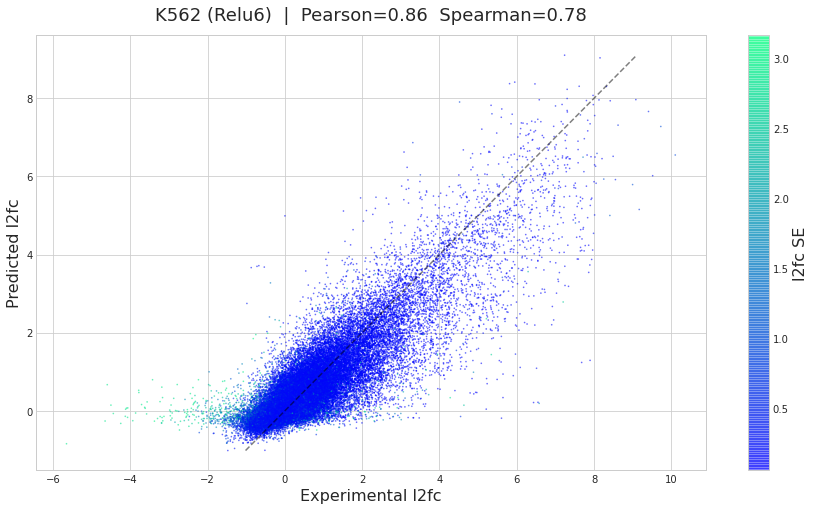

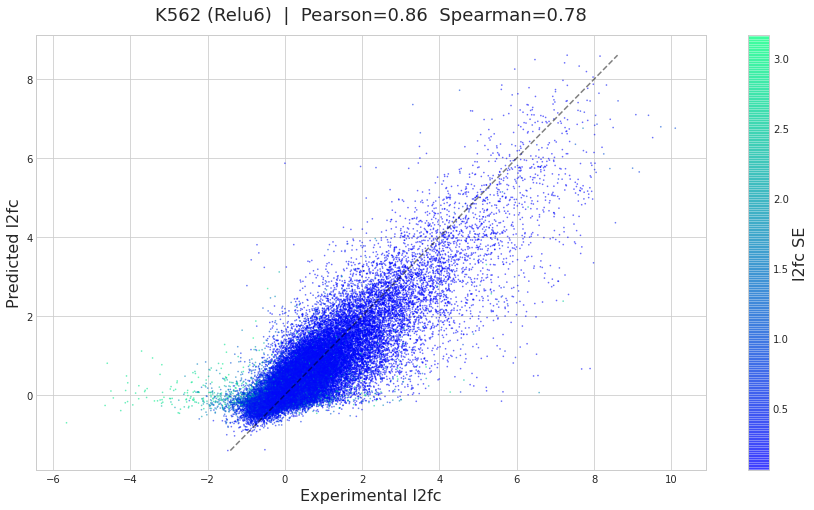

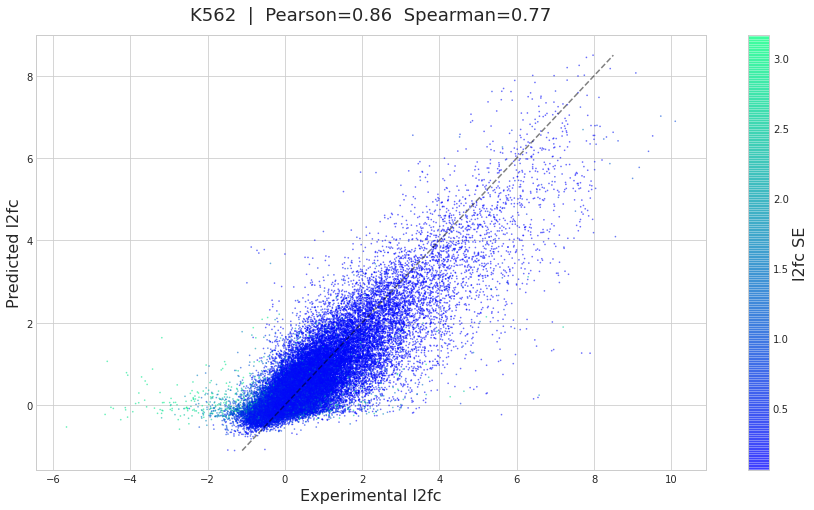

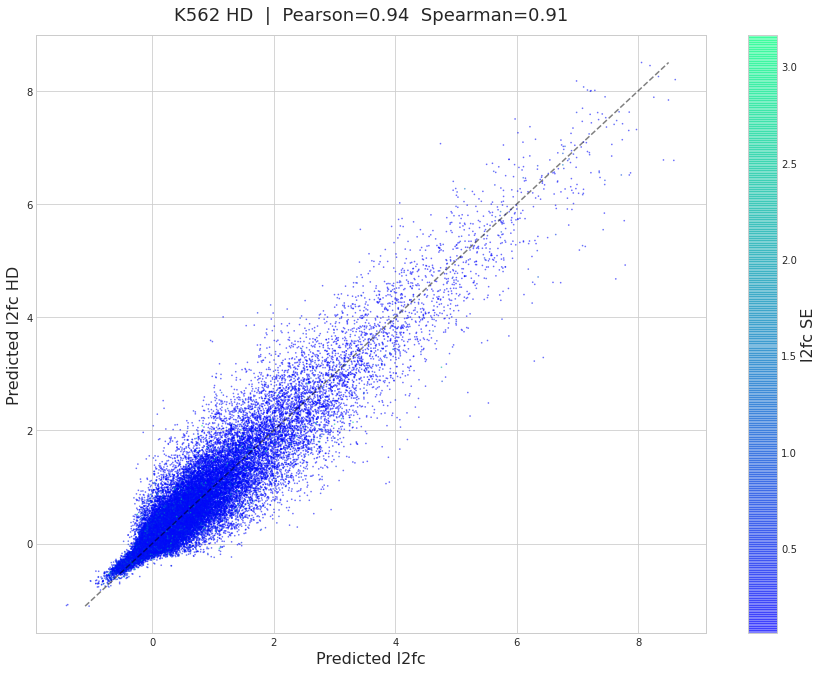

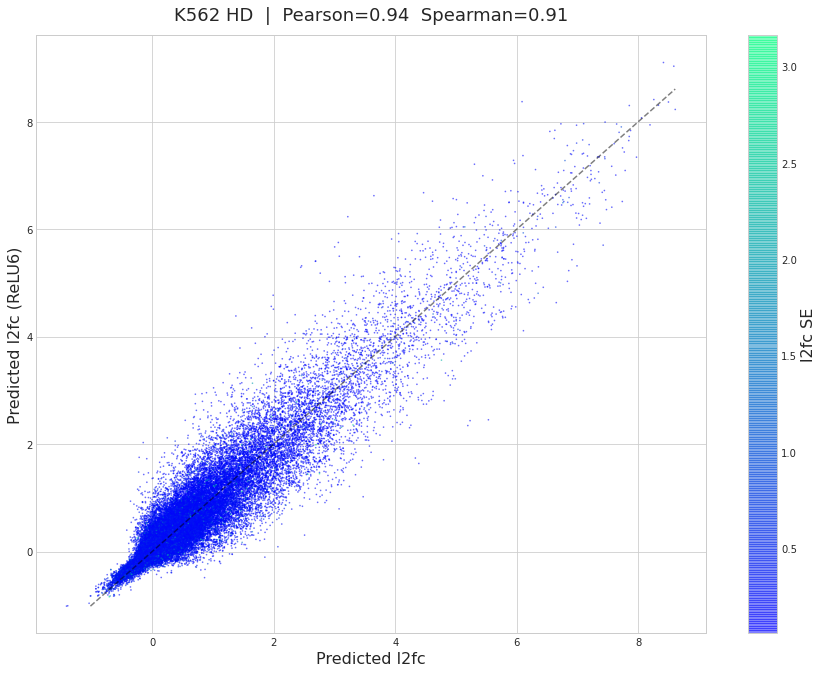

In [27]:
truth = 'K562_mean'
pred = 'K562_pred'
pred6 = 'K562_pred6'
pred_HD = 'K562_pred_HD'
color_axis = 'lfcSE_k562'
titles = ['K562 (Relu6)', 'K562', 'K562 HD', 'K562 Non-HD vs HD', 'K562 ReLU vs ReLU6']
colormap = 'winter'

single_scatterplot(data_df=test_df,
                   x_axis=truth,
                   y_axis=pred6,
                   color_axis=color_axis,
                   fig_size=(15,8),
                   dot_size=0.5,
                   title=titles[0],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Experimental l2fc',
                   y_label='Predicted l2fc',
                   color_label='l2fc SE')

single_scatterplot(data_df=test_df,
                   x_axis=truth,
                   y_axis=pred,
                   color_axis=color_axis,
                   fig_size=(15,8),
                   dot_size=0.5,
                   title=titles[0],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Experimental l2fc',
                   y_label='Predicted l2fc',
                   color_label='l2fc SE')

single_scatterplot(data_df=test_df,
                   x_axis=truth,
                   y_axis=pred_HD,
                   color_axis=color_axis,
                   fig_size=(15,8),
                   dot_size=0.5,
                   title=titles[1],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Experimental l2fc',
                   y_label='Predicted l2fc',
                   color_label='l2fc SE')

single_scatterplot(data_df=test_df,
                   x_axis=pred,
                   y_axis=pred_HD,
                   color_axis=color_axis,
                   fig_size=(15,11),
                   dot_size=0.5,
                   title=titles[2],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Predicted l2fc',
                   y_label='Predicted l2fc HD',
                   color_label='l2fc SE')

single_scatterplot(data_df=test_df,
                   x_axis=pred,
                   y_axis=pred6,
                   color_axis=color_axis,
                   fig_size=(15,11),
                   dot_size=0.5,
                   title=titles[2],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Predicted l2fc',
                   y_label='Predicted l2fc (ReLU6)',
                   color_label='l2fc SE')

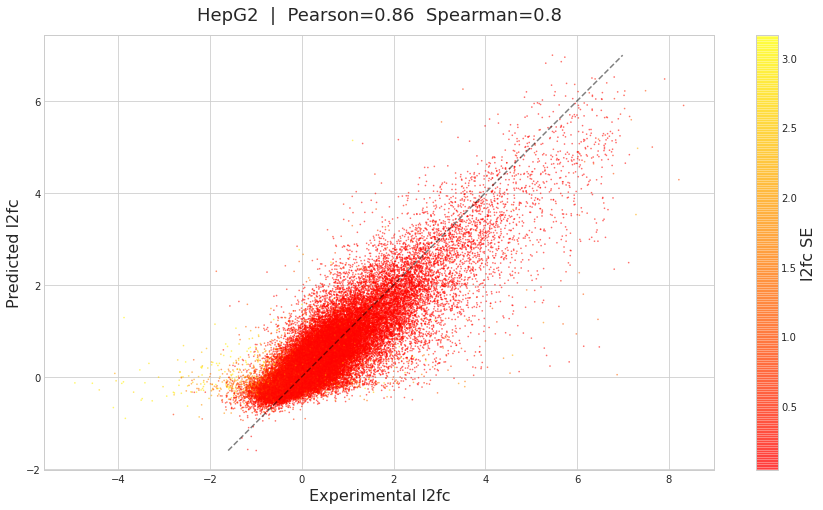

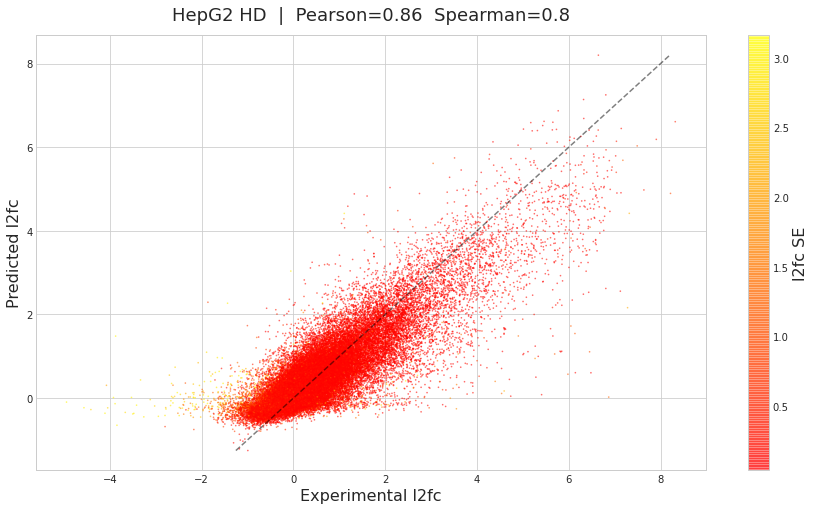

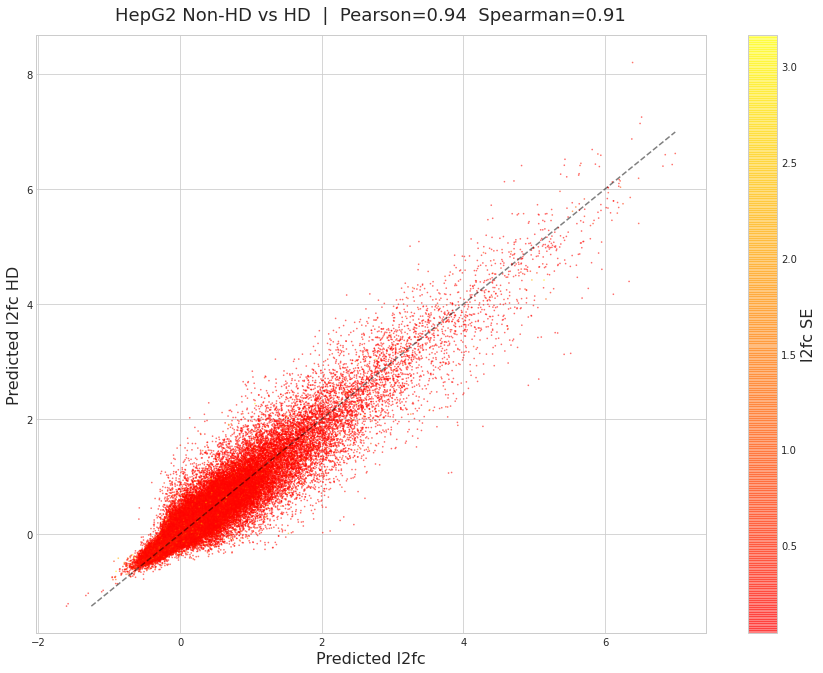

In [17]:
truth = 'HepG2_mean'
pred = 'HepG2_pred'
pred_HD = 'HepG2_pred_HD'
color_axis = 'lfcSE_hepg2'
titles = ['HepG2', 'HepG2 HD', 'HepG2 Non-HD vs HD']
colormap = 'autumn'

single_scatterplot(data_df=test_df,
                   x_axis=truth,
                   y_axis=pred,
                   color_axis=color_axis,
                   fig_size=(15,8),
                   dot_size=0.5,
                   title=titles[0],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Experimental l2fc',
                   y_label='Predicted l2fc',
                   color_label='l2fc SE')

single_scatterplot(data_df=test_df,
                   x_axis=truth,
                   y_axis=pred_HD,
                   color_axis=color_axis,
                   fig_size=(15,8),
                   dot_size=0.5,
                   title=titles[1],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Experimental l2fc',
                   y_label='Predicted l2fc',
                   color_label='l2fc SE')

single_scatterplot(data_df=test_df,
                   x_axis=pred,
                   y_axis=pred_HD,
                   color_axis=color_axis,
                   fig_size=(15,11),
                   dot_size=0.5,
                   title=titles[2],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Predicted l2fc',
                   y_label='Predicted l2fc HD',
                   color_label='l2fc SE')

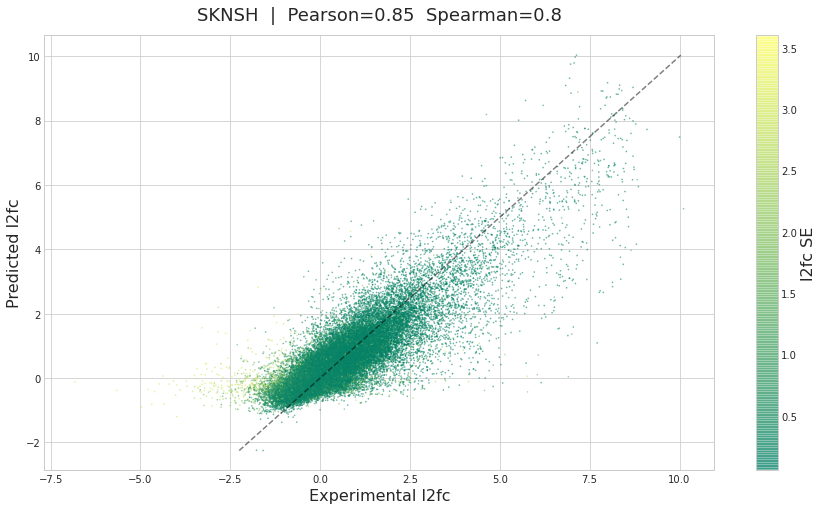

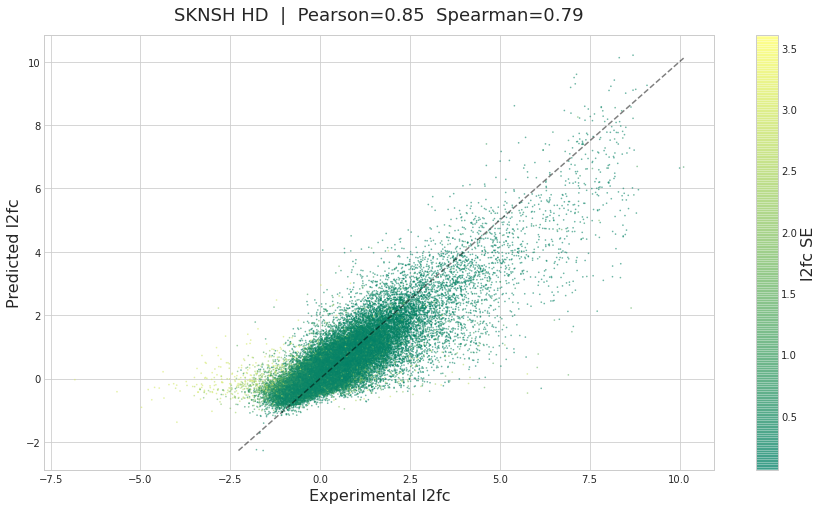

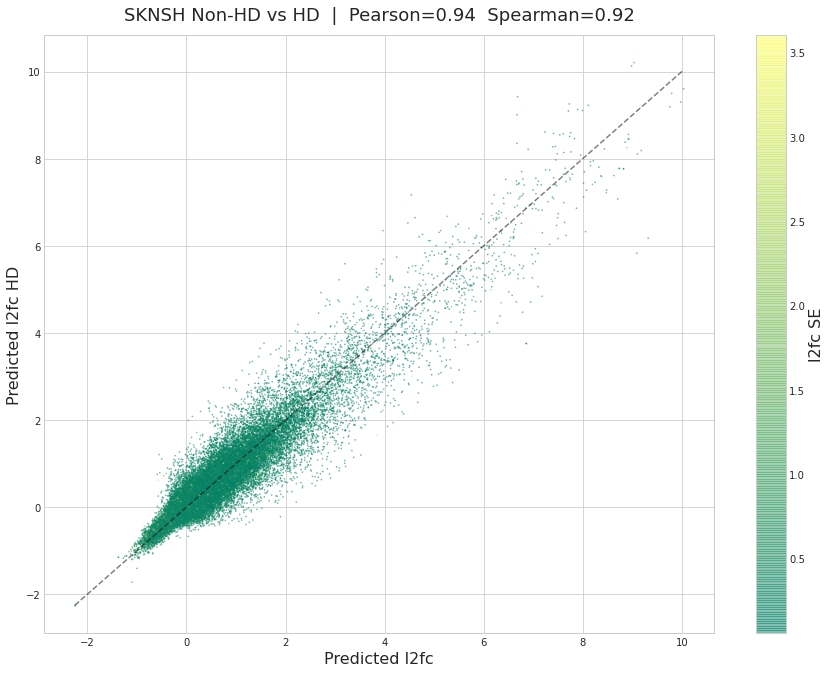

In [18]:
truth = 'SKNSH_mean'
pred = 'SKNSH_pred'
pred_HD = 'SKNSH_pred_HD'
color_axis = 'lfcSE_sknsh'
titles = ['SKNSH', 'SKNSH HD', 'SKNSH Non-HD vs HD']
colormap = 'summer'

single_scatterplot(data_df=test_df,
                   x_axis=truth,
                   y_axis=pred,
                   color_axis=color_axis,
                   fig_size=(15,8),
                   dot_size=0.5,
                   title=titles[0],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Experimental l2fc',
                   y_label='Predicted l2fc',
                   color_label='l2fc SE')

single_scatterplot(data_df=test_df,
                   x_axis=truth,
                   y_axis=pred_HD,
                   color_axis=color_axis,
                   fig_size=(15,8),
                   dot_size=0.5,
                   title=titles[1],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Experimental l2fc',
                   y_label='Predicted l2fc',
                   color_label='l2fc SE')

single_scatterplot(data_df=test_df,
                   x_axis=pred,
                   y_axis=pred_HD,
                   color_axis=color_axis,
                   fig_size=(15,11),
                   dot_size=0.5,
                   title=titles[2],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Predicted l2fc',
                   y_label='Predicted l2fc HD',
                   color_label='l2fc SE')

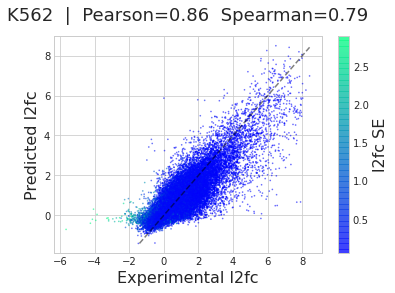

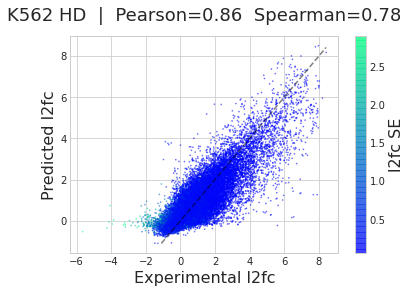

In [19]:
temp_df = test_df[(test_df['ctrl_mean_k562'] >= 20) & (test_df['exp_mean_k562'] > 0)]

truth = 'K562_mean'
pred = 'K562_pred'
pred_HD = 'K562_pred_HD'
color_axis = 'lfcSE_k562'
titles = ['K562', 'K562 HD', 'K562 Non-HD vs HD']
colormap = 'winter'
figsize = (6,4)

single_scatterplot(data_df=temp_df,
                   x_axis=truth,
                   y_axis=pred,
                   color_axis=color_axis,
                   fig_size=figsize,
                   dot_size=0.5,
                   title=titles[0],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Experimental l2fc',
                   y_label='Predicted l2fc',
                   color_label='l2fc SE')

single_scatterplot(data_df=temp_df,
                   x_axis=truth,
                   y_axis=pred_HD,
                   color_axis=color_axis,
                   fig_size=figsize,
                   dot_size=0.5,
                   title=titles[1],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Experimental l2fc',
                   y_label='Predicted l2fc',
                   color_label='l2fc SE')

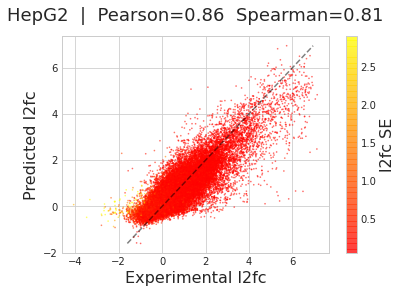

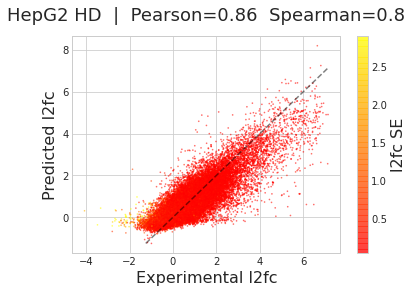

In [20]:
temp_df = test_df[(test_df['ctrl_mean_hepg2'] >= 20) & (test_df['exp_mean_hepg2'] > 0)]

truth = 'HepG2_mean'
pred = 'HepG2_pred'
pred_HD = 'HepG2_pred_HD'
color_axis = 'lfcSE_hepg2'
titles = ['HepG2', 'HepG2 HD', 'HepG2 Non-HD vs HD']
colormap = 'autumn'
figsize = (6,4)

single_scatterplot(data_df=temp_df,
                   x_axis=truth,
                   y_axis=pred,
                   color_axis=color_axis,
                   fig_size=figsize,
                   dot_size=0.5,
                   title=titles[0],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Experimental l2fc',
                   y_label='Predicted l2fc',
                   color_label='l2fc SE')

single_scatterplot(data_df=temp_df,
                   x_axis=truth,
                   y_axis=pred_HD,
                   color_axis=color_axis,
                   fig_size=figsize,
                   dot_size=0.5,
                   title=titles[1],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Experimental l2fc',
                   y_label='Predicted l2fc',
                   color_label='l2fc SE')

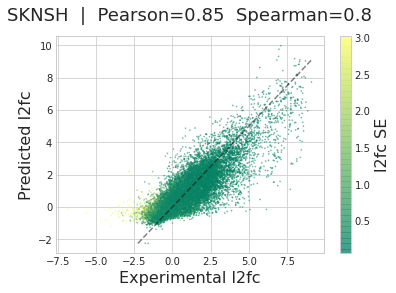

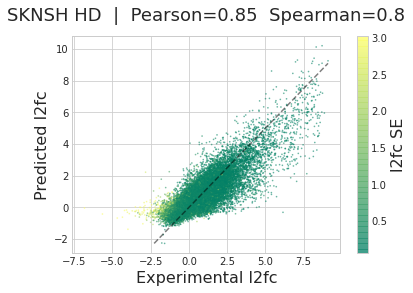

In [21]:
temp_df = test_df[(test_df['ctrl_mean_sknsh'] >= 20) & (test_df['exp_mean_sknsh'] > 0)]

truth = 'SKNSH_mean'
pred = 'SKNSH_pred'
pred_HD = 'SKNSH_pred_HD'
color_axis = 'lfcSE_sknsh'
titles = ['SKNSH', 'SKNSH HD', 'SKNSH Non-HD vs HD']
colormap = 'summer'
figsize = (6,4)

single_scatterplot(data_df=temp_df,
                   x_axis=truth,
                   y_axis=pred,
                   color_axis=color_axis,
                   fig_size=figsize,
                   dot_size=0.5,
                   title=titles[0],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Experimental l2fc',
                   y_label='Predicted l2fc',
                   color_label='l2fc SE')

single_scatterplot(data_df=temp_df,
                   x_axis=truth,
                   y_axis=pred_HD,
                   color_axis=color_axis,
                   fig_size=figsize,
                   dot_size=0.5,
                   title=titles[1],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Experimental l2fc',
                   y_label='Predicted l2fc',
                   color_label='l2fc SE')

In [28]:
locus_df = pd.read_csv('gs://syrgoth/data/MPRA_LocusSelect.txt', sep=" ", low_memory=False)

In [29]:
usual_model.cuda()
preds_array_noHD = get_predictions(locus_df, usual_model)

luocus_preds_df_noHD = pd.DataFrame(preds_array_noHD, columns=['K562_pred', 'HepG2_pred', 'SKNSH_pred'])
locus_df = pd.concat([locus_df, luocus_preds_df_noHD], axis=1)

Padding sequences


  0%|          | 0/99875 [00:00<?, ?it/s]

Tokenizing sequences


  0%|          | 0/99875 [00:00<?, ?it/s]

Getting predictions


  0%|          | 0/781 [00:00<?, ?it/s]

In [32]:
relu6_model.cuda()
preds_array_noHD = get_predictions(locus_df, relu6_model)

luocus_preds_df_noHD = pd.DataFrame(preds_array_noHD, columns=['K562_pred6', 'HepG2_pred6', 'SKNSH_pred6'])
locus_df = pd.concat([locus_df, luocus_preds_df_noHD], axis=1)

Padding sequences


  0%|          | 0/99875 [00:00<?, ?it/s]

Tokenizing sequences


  0%|          | 0/99875 [00:00<?, ?it/s]

Getting predictions


  0%|          | 0/781 [00:00<?, ?it/s]

In [30]:
HD_model.cuda()
preds_array_noHD = get_predictions(locus_df, HD_model)

luocus_preds_df_noHD = pd.DataFrame(preds_array_noHD, columns=['K562_pred_HD', 'HepG2_pred_HD', 'SKNSH_pred_HD'])
locus_df = pd.concat([locus_df, luocus_preds_df_noHD], axis=1)

Padding sequences


  0%|          | 0/99875 [00:00<?, ?it/s]

Tokenizing sequences


  0%|          | 0/99875 [00:00<?, ?it/s]

Getting predictions


  0%|          | 0/781 [00:00<?, ?it/s]

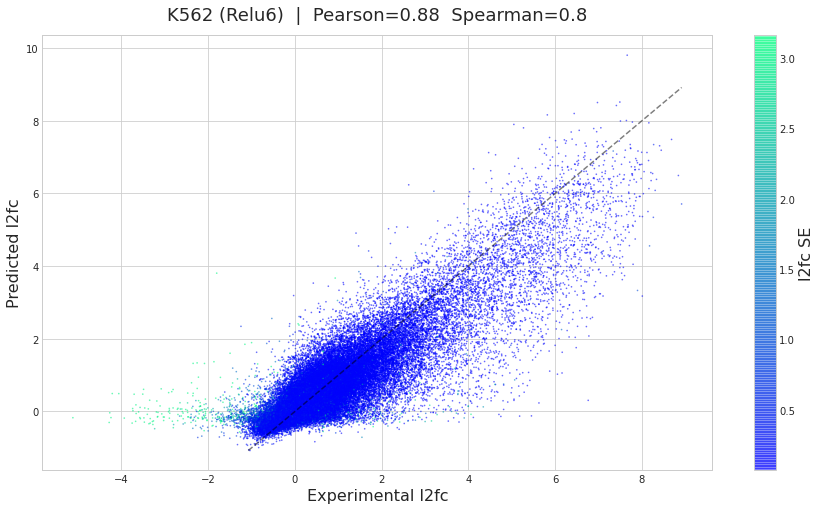

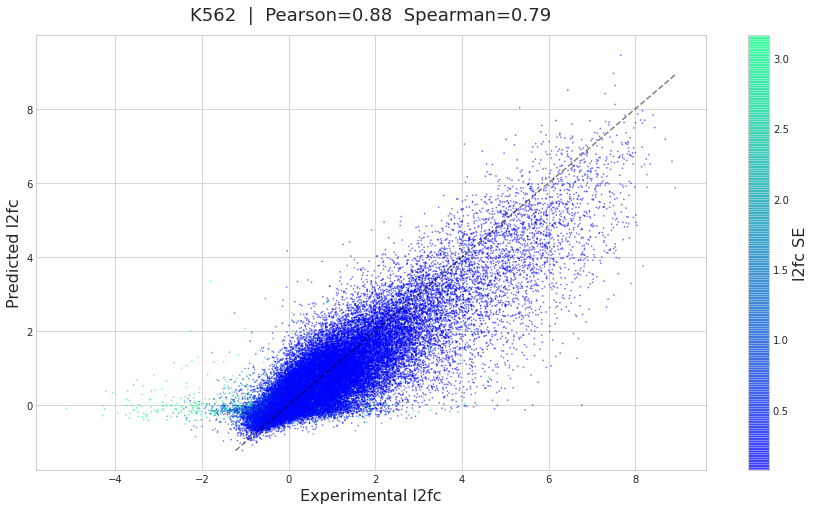

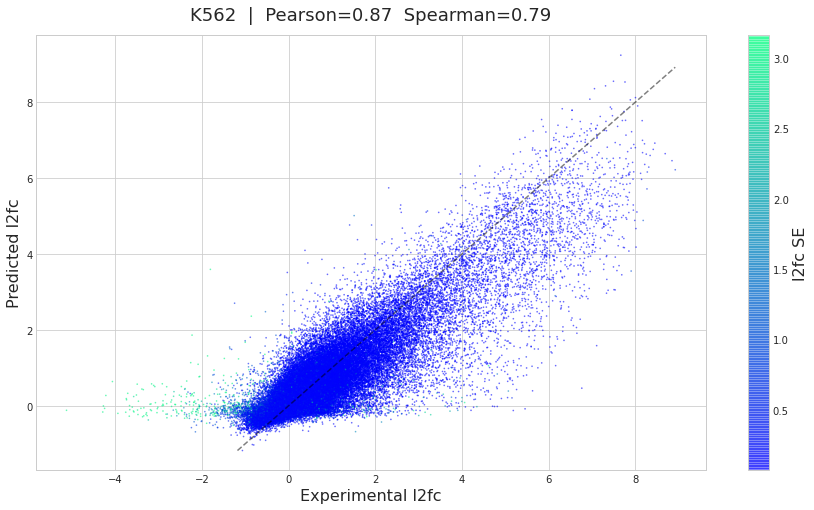

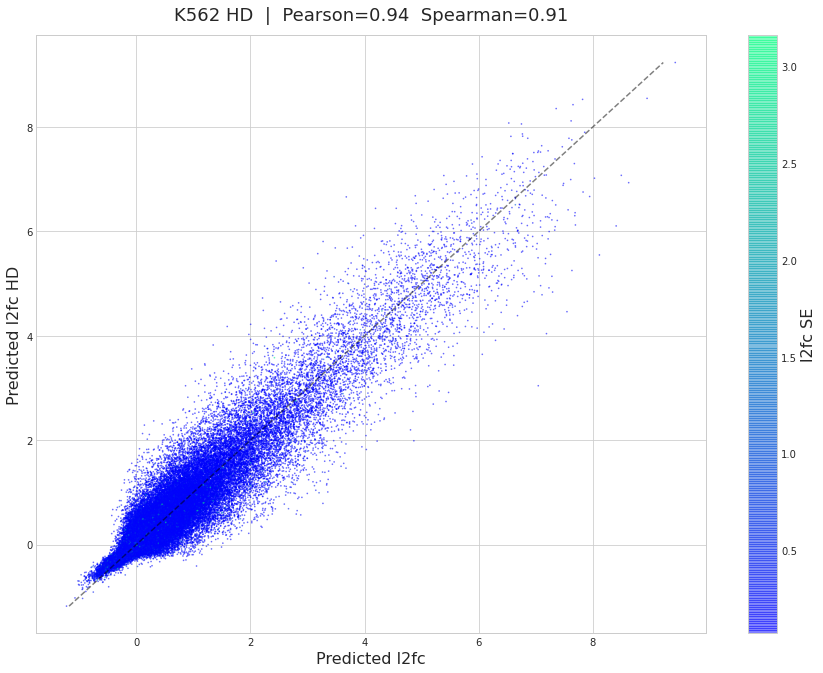

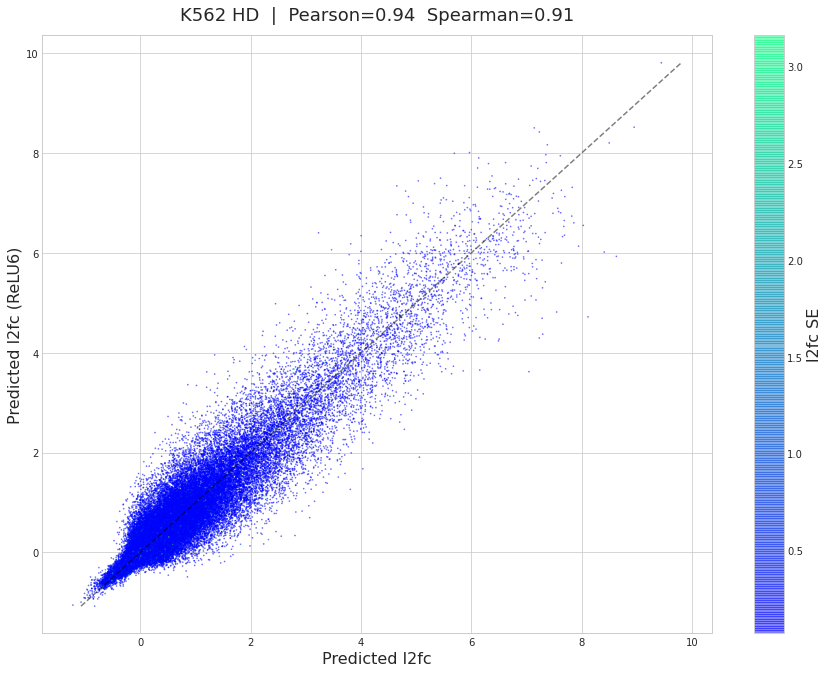

In [38]:
truth = 'log2FoldChange'
pred = 'K562_pred'
pred6 = 'K562_pred6'
pred_HD = 'K562_pred_HD'
color_axis = 'lfcSE'
titles = ['K562 (Relu6)', 'K562', 'K562 HD', 'K562 Non-HD vs HD', 'K562 ReLU vs ReLU6']
colormap = 'winter'

single_scatterplot(data_df=locus_df,
                   x_axis=truth,
                   y_axis=pred6,
                   color_axis=color_axis,
                   fig_size=(15,8),
                   dot_size=0.5,
                   title=titles[0],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Experimental l2fc',
                   y_label='Predicted l2fc',
                   color_label='l2fc SE')

single_scatterplot(data_df=locus_df,
                   x_axis=truth,
                   y_axis=pred,
                   color_axis=color_axis,
                   fig_size=(15,8),
                   dot_size=0.5,
                   title=titles[1],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Experimental l2fc',
                   y_label='Predicted l2fc',
                   color_label='l2fc SE')

single_scatterplot(data_df=locus_df,
                   x_axis=truth,
                   y_axis=pred_HD,
                   color_axis=color_axis,
                   fig_size=(15,8),
                   dot_size=0.5,
                   title=titles[1],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Experimental l2fc',
                   y_label='Predicted l2fc',
                   color_label='l2fc SE')

single_scatterplot(data_df=locus_df,
                   x_axis=pred,
                   y_axis=pred_HD,
                   color_axis=color_axis,
                   fig_size=(15,11),
                   dot_size=0.5,
                   title=titles[2],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Predicted l2fc',
                   y_label='Predicted l2fc HD',
                   color_label='l2fc SE')

single_scatterplot(data_df=locus_df,
                   x_axis=pred,
                   y_axis=pred6,
                   color_axis=color_axis,
                   fig_size=(15,11),
                   dot_size=0.5,
                   title=titles[2],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Predicted l2fc',
                   y_label='Predicted l2fc (ReLU6)',
                   color_label='l2fc SE')

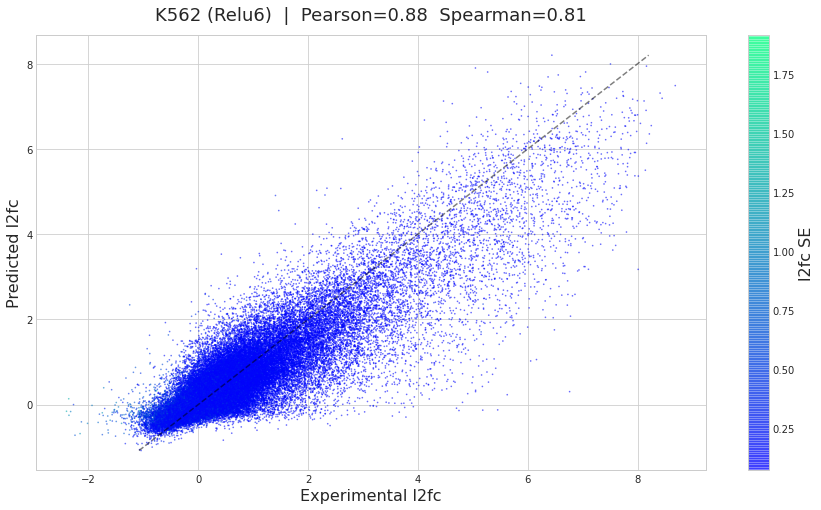

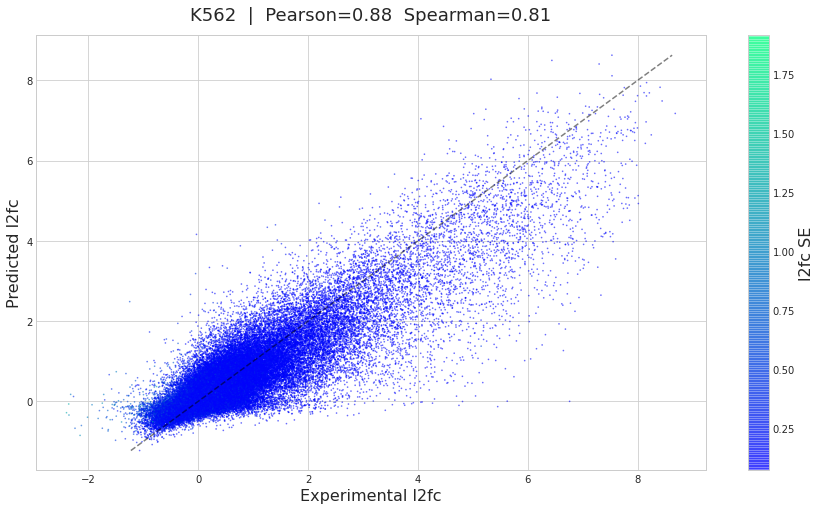

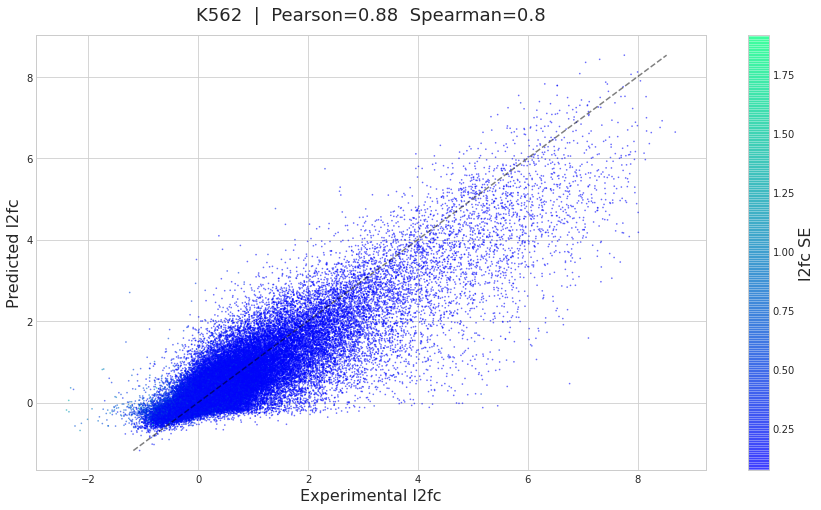

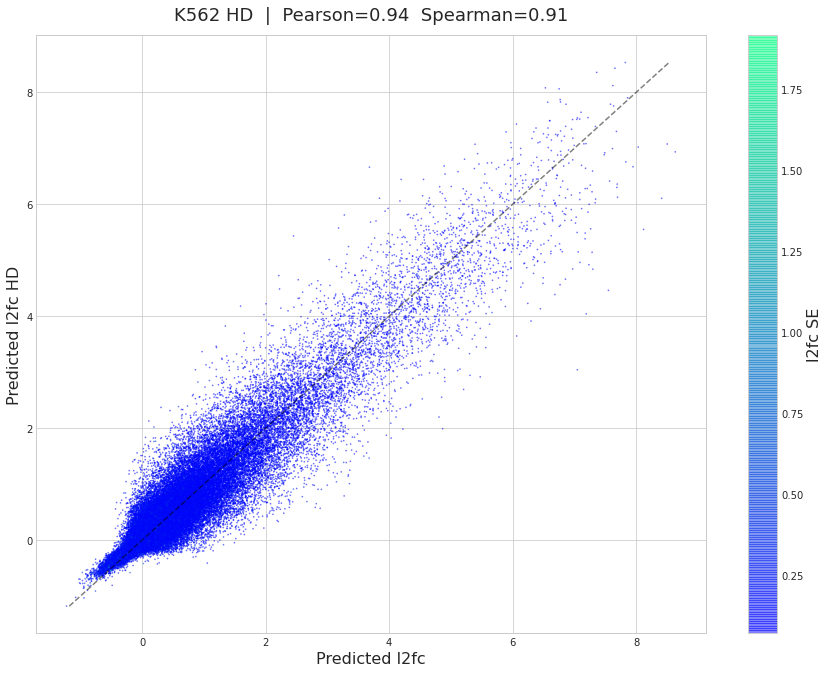

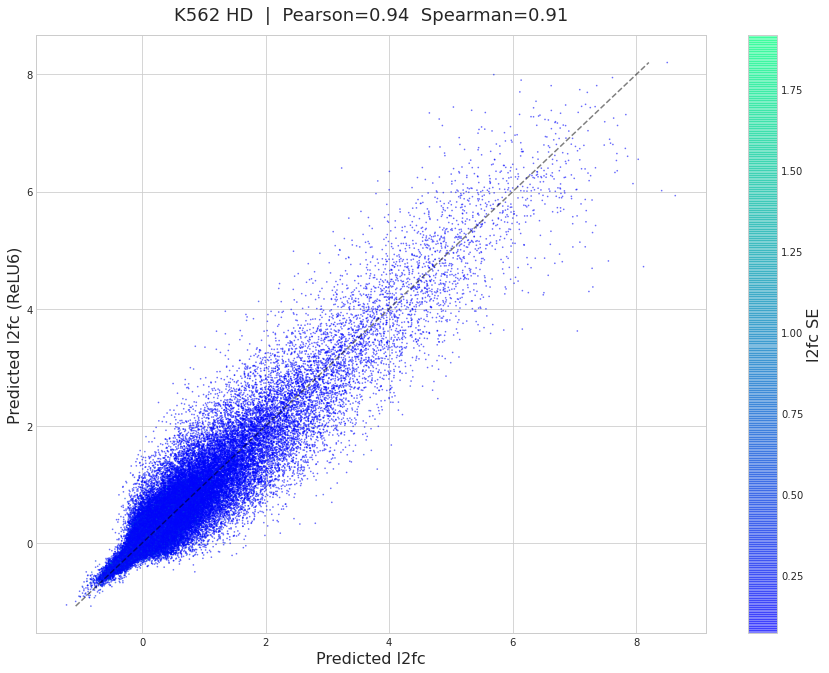

In [42]:
temp_df = locus_df[(locus_df['Ctrl.Mean'] >= 20) & (locus_df['Exp.Mean'] > 0)]
temp_df = temp_df[(temp_df['project'] == 'Tiles-GATA') | (temp_df['project'] == 'Tiles-MYC')]

single_scatterplot(data_df=temp_df,
                   x_axis=truth,
                   y_axis=pred6,
                   color_axis=color_axis,
                   fig_size=(15,8),
                   dot_size=0.5,
                   title=titles[0],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Experimental l2fc',
                   y_label='Predicted l2fc',
                   color_label='l2fc SE')

single_scatterplot(data_df=temp_df,
                   x_axis=truth,
                   y_axis=pred,
                   color_axis=color_axis,
                   fig_size=(15,8),
                   dot_size=0.5,
                   title=titles[1],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Experimental l2fc',
                   y_label='Predicted l2fc',
                   color_label='l2fc SE')

single_scatterplot(data_df=temp_df,
                   x_axis=truth,
                   y_axis=pred_HD,
                   color_axis=color_axis,
                   fig_size=(15,8),
                   dot_size=0.5,
                   title=titles[1],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Experimental l2fc',
                   y_label='Predicted l2fc',
                   color_label='l2fc SE')

single_scatterplot(data_df=temp_df,
                   x_axis=pred,
                   y_axis=pred_HD,
                   color_axis=color_axis,
                   fig_size=(15,11),
                   dot_size=0.5,
                   title=titles[2],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Predicted l2fc',
                   y_label='Predicted l2fc HD',
                   color_label='l2fc SE')

single_scatterplot(data_df=temp_df,
                   x_axis=pred,
                   y_axis=pred6,
                   color_axis=color_axis,
                   fig_size=(15,11),
                   dot_size=0.5,
                   title=titles[2],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Predicted l2fc',
                   y_label='Predicted l2fc (ReLU6)',
                   color_label='l2fc SE')

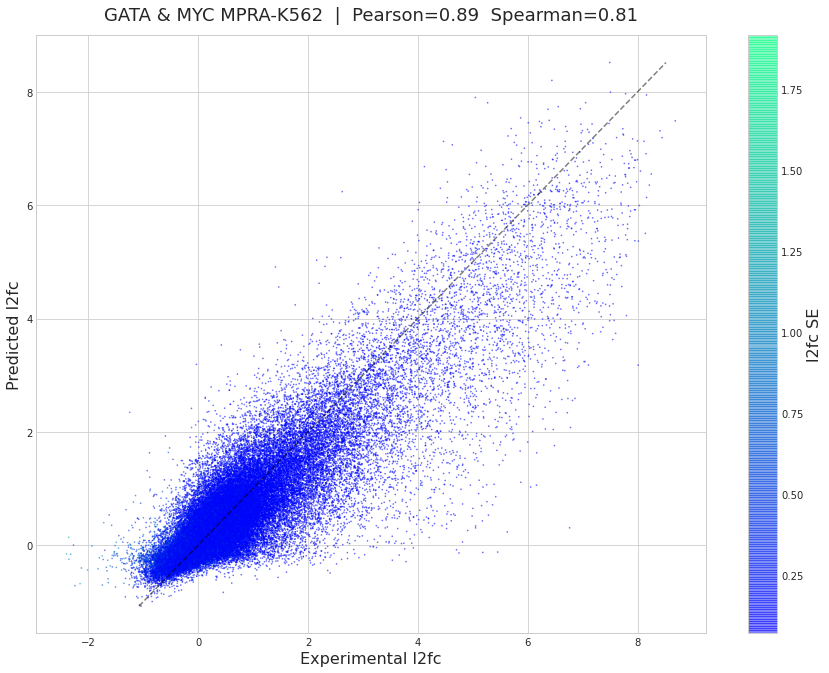

In [37]:
single_scatterplot(data_df=temp_df,
                   x_axis=truth,
                   y_axis=pred6,
                   color_axis=color_axis,
                   fig_size=(15,11),
                   dot_size=0.5,
                   title='GATA & MYC MPRA-K562',
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Experimental l2fc',
                   y_label='Predicted l2fc',
                   color_label='l2fc SE')

In [31]:
locus_df.columns

Index(['ID', 'SNP', 'chr', 'snp_pos', 'ref_allele', 'alt_allele', 'allele',
       'window', 'strand', 'start', 'stop', 'project', 'haplotype',
       'Ctrl.Mean', 'Exp.Mean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue',
       'padj', 'nt_sequence', 'padded_seq', 'K562_pred', 'HepG2_pred',
       'SKNSH_pred', 'K562_pred_HD', 'HepG2_pred_HD', 'SKNSH_pred_HD'],
      dtype='object')

In [40]:
temp_df['project']

0          ctrl_pos
1          ctrl_neg
2          ctrl_pos
3          ctrl_pos
4          ctrl_pos
            ...    
99870    Tiles-GATA
99871    Tiles-GATA
99872    Tiles-GATA
99873      ctrl_pos
99874      ctrl_neg
Name: project, Length: 96342, dtype: object

In [66]:
cms_df = pd.read_csv('gs://syrgoth/data/MPRA_CMS.txt', sep=" ", low_memory=False)

In [69]:
cms_df = cms_df[cms_df['nt_sequence'] != ' '].reset_index(drop=True)

In [70]:
usual_model.cuda()
preds_array_noHD = get_predictions(cms_df, usual_model)
cms_preds_df_noHD = pd.DataFrame(preds_array_noHD, columns=['K562_pred', 'HepG2_pred', 'SKNSH_pred'])
cms_df = pd.concat([cms_df, cms_preds_df_noHD], axis=1)

relu6_model.cuda()
preds_array_noHD = get_predictions(cms_df, relu6_model)
cms_preds_df_noHD = pd.DataFrame(preds_array_noHD, columns=['K562_pred6', 'HepG2_pred6', 'SKNSH_pred6'])
cms_df = pd.concat([cms_df, cms_preds_df_noHD], axis=1)

HD_model.cuda()
preds_array_HD = get_predictions(cms_df, HD_model)
cms_preds_df_HD = pd.DataFrame(preds_array_HD, columns=['K562_pred_HD', 'HepG2_pred_HD', 'SKNSH_pred_HD'])
cms_df = pd.concat([cms_df, cms_preds_df_HD], axis=1)

Padding sequences


  0%|          | 0/58712 [00:00<?, ?it/s]

Tokenizing sequences


  0%|          | 0/58712 [00:00<?, ?it/s]

Getting predictions


  0%|          | 0/459 [00:00<?, ?it/s]

Padding sequences


  0%|          | 0/58712 [00:00<?, ?it/s]

Tokenizing sequences


  0%|          | 0/58712 [00:00<?, ?it/s]

Getting predictions


  0%|          | 0/459 [00:00<?, ?it/s]

Padding sequences


  0%|          | 0/58712 [00:00<?, ?it/s]

Tokenizing sequences


  0%|          | 0/58712 [00:00<?, ?it/s]

Getting predictions


  0%|          | 0/459 [00:00<?, ?it/s]

In [72]:
cms_df.columns

Index(['nt_sequence', 'HepG2_mean', 'K562_mean', 'SKNSH_mean', 'HepG2_std',
       'K562_std', 'SKNSH_std', 'chr', 'class', 'IDs', 'exp_mean_hepg2',
       'exp_mean_k562', 'exp_mean_sknsh', 'ctrl_mean_hepg2', 'ctrl_mean_k562',
       'ctrl_mean_sknsh', 'lfcSE_hepg2', 'lfcSE_k562', 'lfcSE_sknsh',
       'ID_count', 'padded_seq', 'K562_pred', 'HepG2_pred', 'SKNSH_pred',
       'K562_pred6', 'HepG2_pred6', 'SKNSH_pred6', 'K562_pred_HD',
       'HepG2_pred_HD', 'SKNSH_pred_HD'],
      dtype='object')

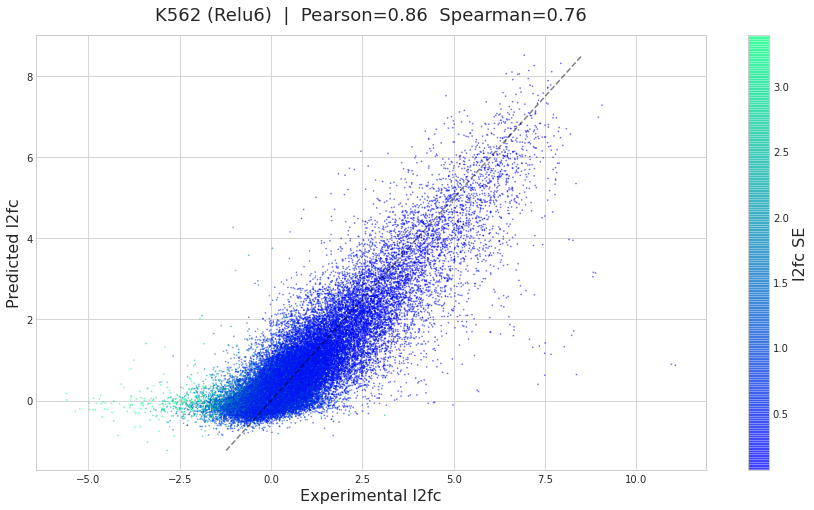

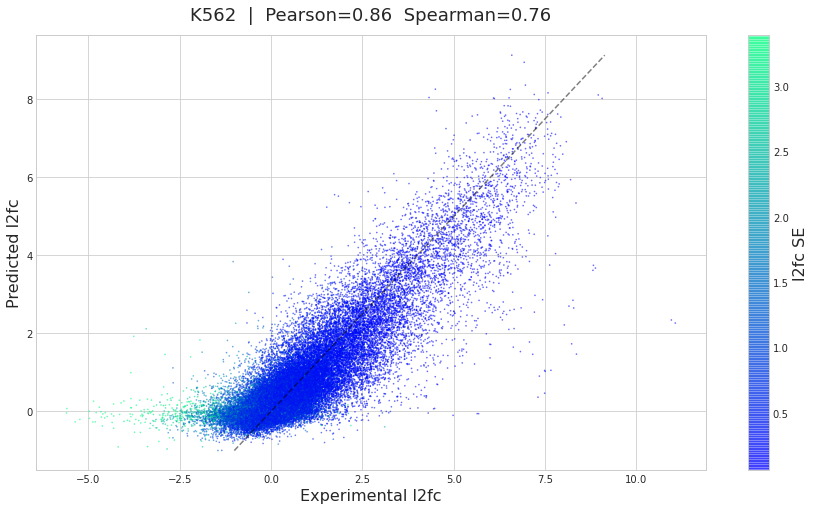

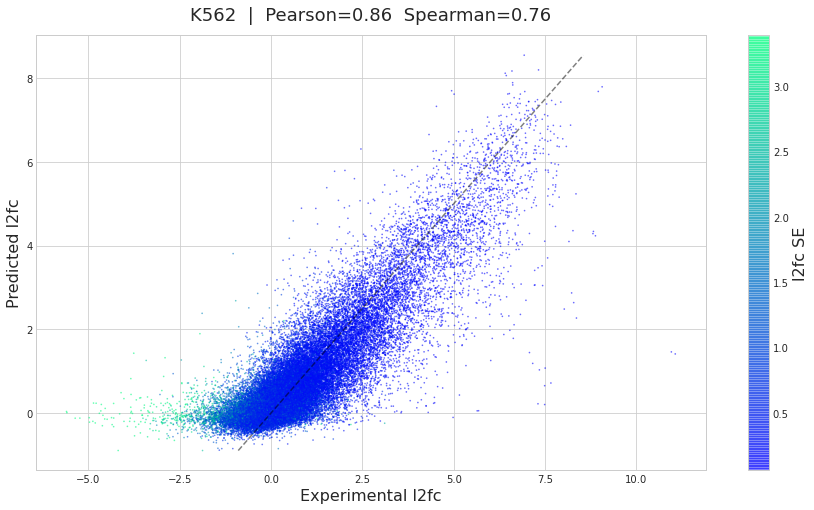

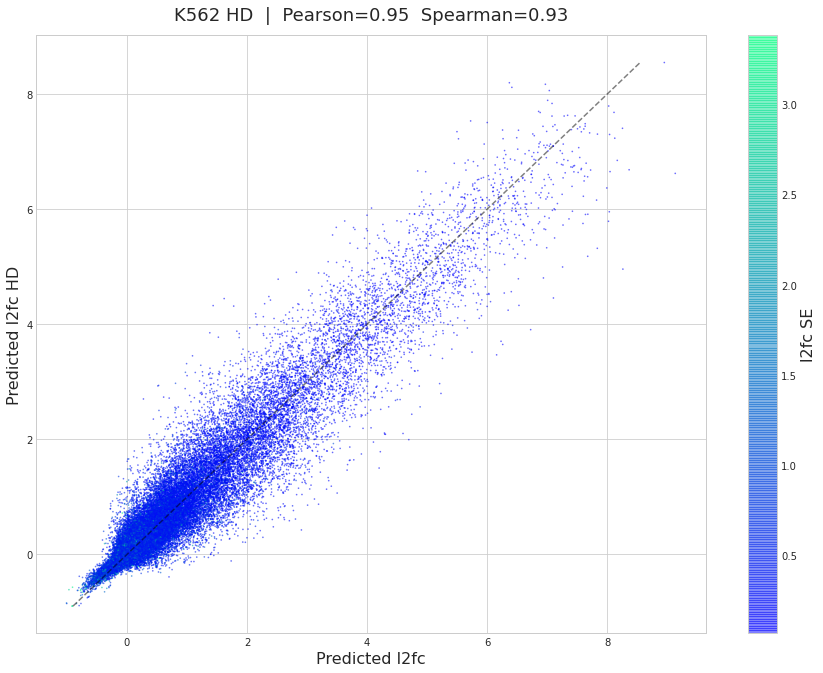

In [74]:
temp_df = cms_df[(cms_df['ctrl_mean_k562'] >= 20) & (cms_df['exp_mean_k562'] > 0)]

truth = 'K562_mean'
pred = 'K562_pred'
pred6 = 'K562_pred6'
pred_HD = 'K562_pred_HD'
color_axis = 'lfcSE_k562'
titles = ['K562 (Relu6)', 'K562', 'K562 HD', 'K562 Non-HD vs HD', 'K562 ReLU vs ReLU6']
colormap = 'winter'

single_scatterplot(data_df=temp_df,
                   x_axis=truth,
                   y_axis=pred6,
                   color_axis=color_axis,
                   fig_size=(15,8),
                   dot_size=0.5,
                   title=titles[0],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Experimental l2fc',
                   y_label='Predicted l2fc',
                   color_label='l2fc SE')

single_scatterplot(data_df=temp_df,
                   x_axis=truth,
                   y_axis=pred,
                   color_axis=color_axis,
                   fig_size=(15,8),
                   dot_size=0.5,
                   title=titles[1],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Experimental l2fc',
                   y_label='Predicted l2fc',
                   color_label='l2fc SE')

single_scatterplot(data_df=temp_df,
                   x_axis=truth,
                   y_axis=pred_HD,
                   color_axis=color_axis,
                   fig_size=(15,8),
                   dot_size=0.5,
                   title=titles[1],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Experimental l2fc',
                   y_label='Predicted l2fc',
                   color_label='l2fc SE')

single_scatterplot(data_df=temp_df,
                   x_axis=pred,
                   y_axis=pred_HD,
                   color_axis=color_axis,
                   fig_size=(15,11),
                   dot_size=0.5,
                   title=titles[2],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Predicted l2fc',
                   y_label='Predicted l2fc HD',
                   color_label='l2fc SE')

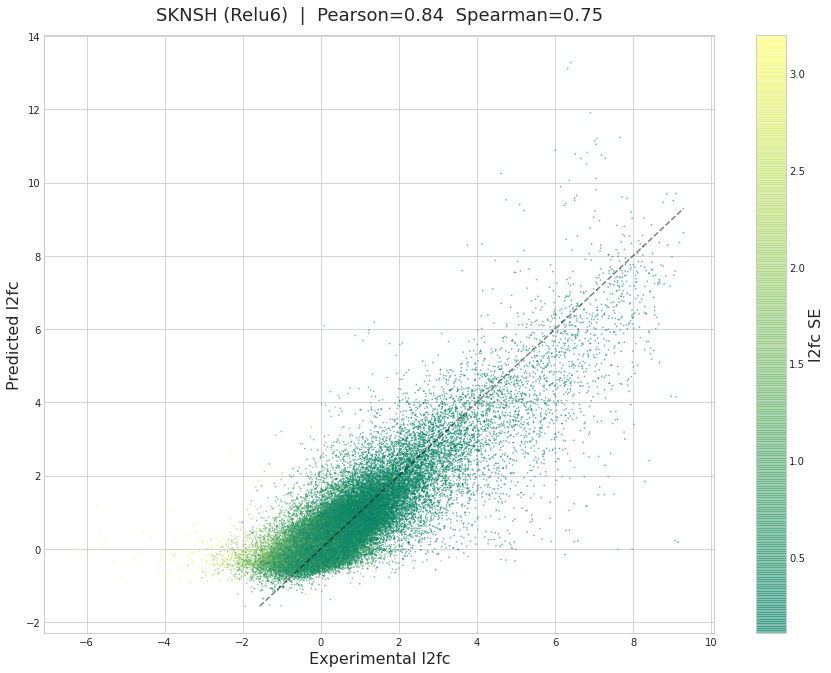

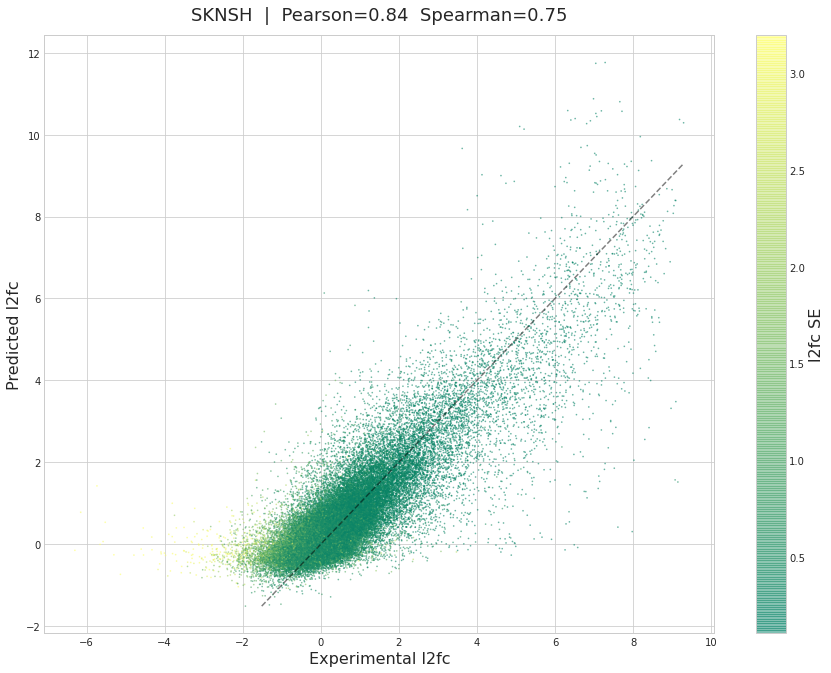

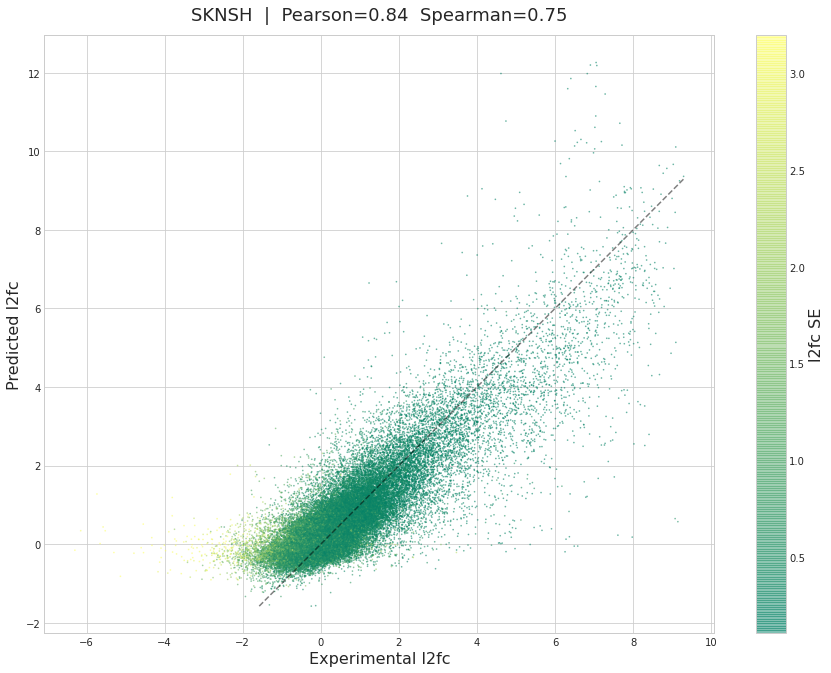

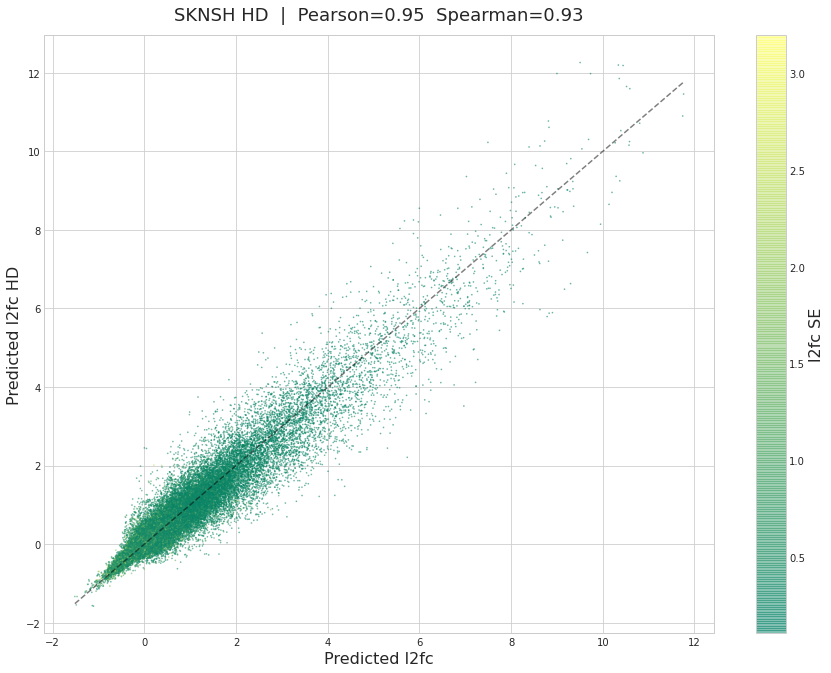

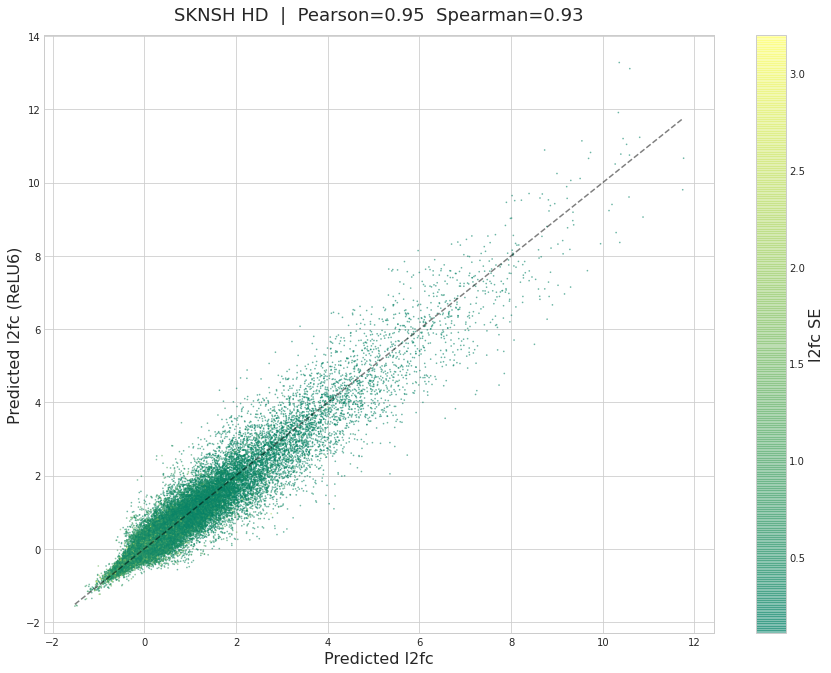

In [79]:
temp_df = cms_df[(cms_df['ctrl_mean_sknsh'] >= 20) & (cms_df['exp_mean_sknsh'] > 0)]

truth = 'SKNSH_mean'
pred = 'SKNSH_pred'
pred6 = 'SKNSH_pred6'
pred_HD = 'SKNSH_pred_HD'
color_axis = 'lfcSE_sknsh'
titles = ['SKNSH (Relu6)', 'SKNSH', 'SKNSH HD', 'SKNSH Non-HD vs HD', 'SKNSH ReLU vs ReLU6']
colormap = 'summer'

single_scatterplot(data_df=temp_df,
                   x_axis=truth,
                   y_axis=pred6,
                   color_axis=color_axis,
                   fig_size=(15,11),
                   dot_size=0.5,
                   title=titles[0],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Experimental l2fc',
                   y_label='Predicted l2fc',
                   color_label='l2fc SE')

single_scatterplot(data_df=temp_df,
                   x_axis=truth,
                   y_axis=pred,
                   color_axis=color_axis,
                   fig_size=(15,11),
                   dot_size=0.5,
                   title=titles[1],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Experimental l2fc',
                   y_label='Predicted l2fc',
                   color_label='l2fc SE')

single_scatterplot(data_df=temp_df,
                   x_axis=truth,
                   y_axis=pred_HD,
                   color_axis=color_axis,
                   fig_size=(15,11),
                   dot_size=0.5,
                   title=titles[1],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Experimental l2fc',
                   y_label='Predicted l2fc',
                   color_label='l2fc SE')

single_scatterplot(data_df=temp_df,
                   x_axis=pred,
                   y_axis=pred_HD,
                   color_axis=color_axis,
                   fig_size=(15,11),
                   dot_size=0.5,
                   title=titles[2],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Predicted l2fc',
                   y_label='Predicted l2fc HD',
                   color_label='l2fc SE')

single_scatterplot(data_df=temp_df,
                   x_axis=pred,
                   y_axis=pred6,
                   color_axis=color_axis,
                   fig_size=(15,11),
                   dot_size=0.5,
                   title=titles[2],
                   dot_alpha=0.5,
                   colormap=colormap,
                   x_label='Predicted l2fc',
                   y_label='Predicted l2fc (ReLU6)',
                   color_label='l2fc SE')